# Assignment_1

**Student no: R00195231**

External Dependencies

* `pip install pandas`
* `pip install nltk`
* `pip install sklearn`
* `pip install matplotlib`


In [1]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

Downloading stopwords list for nltk. It will be used later for text pre-processing

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Task 1 - Load data from .tsv file

Dataset is downloaded from link given in assignment and it should be present in root dirtectory of project. I haven't included due to its large size. 

In [3]:
class DataStoragePath:
    """Class for data storage paths"""
    TRAIN_DATA_PATH = "MADAR-Corpus-26-train.tsv"
    TEST_DATA_PATH = "MADAR-Corpus-26-dev.tsv"

#### Train_Data_Visualization

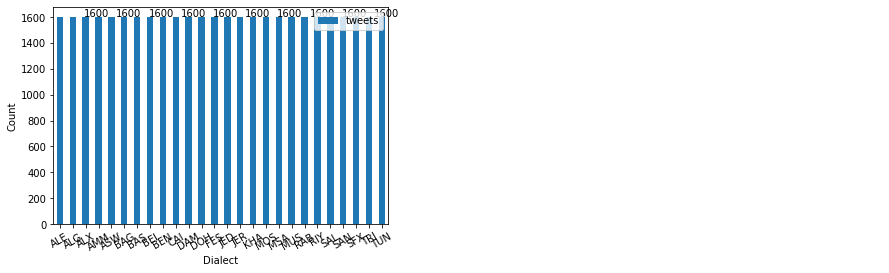

In [4]:
train_data = pd.read_csv(DataStoragePath.TRAIN_DATA_PATH, sep='\t')
train_data.columns = ['tweets', 'dialect']

axes = train_data.groupby("dialect").count().plot.bar()
axes.set_xlabel('Dialect')
axes.set_ylabel('Count')
plt.sca(axes)
plt.xticks(rotation=30)
for p in axes.patches:
    axes.annotate(str(p.get_height()), (p.get_x() * 2.5, p.get_height() * 1.005))
print()

In [5]:
print(f"Shape: {train_data.shape}")

train_data.head()

Shape: (41599, 2)


,tweets,dialect
0,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,MSA
1,استمر في السير في هذا الطريق حتى تجد صيدلية .,MSA
2,كم تكلفة الإفطار ؟,MSA
3,كيف أستطيع مساعدتك ؟,MSA
4,اتجه يسارا عند الناصية الثالثة .,MSA


#### Test Data Visualization

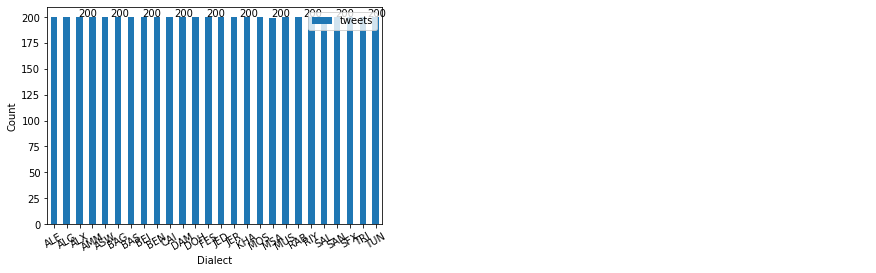

In [6]:
test_data = pd.read_csv(DataStoragePath.TEST_DATA_PATH, sep='\t')
test_data.columns = ['tweets', 'dialect']

axes = test_data.groupby("dialect").count().plot.bar()
axes.set_xlabel('Dialect')
axes.set_ylabel('Count')
plt.sca(axes)
plt.xticks(rotation=30)
for p in axes.patches:
    axes.annotate(str(p.get_height()), (p.get_x() * 2.5, p.get_height() * 1.005))
print()

In [7]:
print(f"Shape: {test_data.shape}")

test_data.head()

Shape: (5199, 2)


,tweets,dialect
0,"هذا القطار يتوقف في لاك فورست , أليس كذلك ؟",MSA
1,"هذا الكارت , حسناً ؟",MSA
2,لم يخرج من الماكينة شيء .,MSA
3,عندك أية شيء يمكن أن أتعاطه للطفح الجلدي ؟,MSA
4,أكيدا التي تتحدث معك ، أنا عندي حجز مائدة في ت...,MSA


#### Text pre-processing steps used 


* **Minimum term length**: Exclude terms of length < 2: Done automatically by scikit-learn's vectorizer
* **Case conversion**: Converting all terms to lowercase. Done automatically by scikit-learn's vectorizer. But I performed it due     to caution.
* **Word Stemming**: Process to reduce a term to its canonical form.
* **Stop-word filtering**: Remove terms that appear on a pre-defined filter list of terms that are highly frequent and don not       convey useful information.
* **Low frequency filtering**: Remove terms that appear in very few documents.
* **Term weighting**: Giving heigher weights to more "important" terms. Used *TF-IDF* approach. Giving more weight when a term         appears multiple times in a single document and penalizsing common terms that appear in almost every document.

#### Text Preprocessing Method

In [8]:
def preprocessing(data, infrequent_words_removal_count=10):
    # Making all letters lowercase
    data["tweets"] = data["tweets"].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing Punctuation, Symbols
    data['tweets'] = data['tweets'].str.replace('[^\w\s]', ' ')

    # Code to find the top 10 rarest words appearing in the data
    freq = pd.Series(' '.join(data["tweets"]).split()).value_counts()[-infrequent_words_removal_count:]

    # Removing all those rarely appearing words from the data
    freq = list(freq.index)
    data["tweets"] = data["tweets"].apply(
        lambda line: " ".join(line for line in line.split() if line not in freq))

    # Removing repeating words 
    def de_repeat(text):
        pattern = re.compile(r"(.)\1{2,}")
        return pattern.sub("r\1\1", text)

    data["tweets"] = data["tweets"].apply(lambda line: " ".join(de_repeat(line) for line in line.split()))
    return data

In [9]:
train_data = preprocessing(train_data,10000)

In [10]:
print(f"Shape: {train_data.shape}")

train_data.head()

Shape: (41599, 2)


,tweets,dialect
0,لم بهذا العنوان من قبل بالقرب من هنا,MSA
1,استمر في السير في هذا الطريق حتى تجد صيدلية,MSA
2,كم تكلفة الإفطار,MSA
3,كيف أستطيع مساعدتك,MSA
4,اتجه يسارا عند الناصية الثالثة,MSA


In [11]:
test_data = preprocessing(test_data)

In [12]:
print(f"Shape: {test_data.shape}")

test_data.head()

Shape: (5199, 2)


,tweets,dialect
0,هذا القطار يتوقف في لاك فورست أليس كذلك,MSA
1,هذا الكارت حسنا,MSA
2,لم يخرج من الماكينة شيء,MSA
3,عندك أية شيء يمكن أن أتعاطه للطفح الجلدي,MSA
4,أكيدا التي تتحدث معك أنا عندي حجز مائدة في تما...,MSA


####  Stopwords  

In [13]:
## Removing Stop Words using NLTK 
stemmer = nltk.stem.isri.ISRIStemmer()
stemmed_stop_words = [stemmer.stem(words) for words in stopwords.words()]
print("Sample stopwords:", stemmed_stop_words[0:10])


Sample stopwords: ['اذ', 'اذا', 'اذم', 'اذن', 'اف', 'اقل', 'كثر', 'الا', 'الا', 'التي']


In [14]:
def neat_score(score):
    """A method to get percentage values rounded up to 2 decimal places from the score"""
    return round(score*100, 2)

#### Conversion of labels into numerric values

Dialect should be converted into numeric values so that these might used in vectorization for both train-data and test-data.

##### For Train Data

In [15]:
from sklearn import preprocessing
y_encoder = preprocessing.LabelEncoder()
y_encoder.fit(['ALE', 'ALG', 'ALX', 'AMM', 'ASW', 'BAG', 'BAS', 'BEI','BEN', 'CAI', 'DAM', 'DOH', 'FES', 'JED', 'JER', 'KHA', 'MOS', 'MUS', 'RAB', 'RIY', 'SAL','SAN', 'SFX', 'TRI', 'TUN', 'MSA'])

LabelEncoder()

In [16]:
def transform_label_into_Y_Encoder(data):
    
    dialect = y_encoder.classes_
    # print(dialect)

    dialect_num_label = dict()
    for idx, lbl in enumerate(dialect):
        dialect_num_label[idx] = lbl
    # print(dialect_num_label)

    y_dialect = y_encoder.fit_transform(data['dialect'].values)
    # print(y_dialect_train)
    return y_dialect

In [17]:
y_dialect_train = transform_label_into_Y_Encoder(train_data)

In [18]:
print("Dialect is converted into numbers : " ,y_dialect_train)
print("Length of total row in train data : ", len(y_dialect_train))

Dialect is converted into numbers :  [17 17 17 ... 24 24 24]
Length of total row in train data :  41599


##### For Test Data

In [19]:
y_dialect_test = transform_label_into_Y_Encoder(test_data)

In [20]:
print("Dialect is converted into numbers : " ,y_dialect_train)
print("Length of total row in test data : ", len(y_dialect_train))

Dialect is converted into numbers :  [17 17 17 ... 24 24 24]
Length of total row in test data :  41599


 ##### Using nltk's ISRIStemmer

Arabic Stemming without a root dictionary. A few minor modifications have been made to ISRI basic algorithm. 
`isri.stem(token)` returns Arabic root for the given token.

   

In [21]:
def stem_tokenizer(text):
    # Get tokens from the text. Tokens of size < 2 will be removed automatically.
    tokenizer = CountVectorizer().build_tokenizer()
    tokens = tokenizer(text)

    # stemming all tokens one by one.
    stemmer = nltk.stem.isri.ISRIStemmer()
    stem_tokens = []
    for token in tokens:
        stem_tokens.append(stemmer.stem(token))

    return stem_tokens

We are using a `TfidfVectorizer`. This approach gives more weight when a term appears multiple times in a single statement and penalizes common terms that appear in almost every stamement.

#### Parameters

* `stopwords` - We are passing the stop words which will be removed from the body of text after tokenization
* `min_df` - The minimum no of documents in which a term should appear to be included in doucment-term matrix. It is currently choosen as 5.
* `tokenizer` - A custom function which will tokenize the text. We are passing a tokenizer which will first create the tokens and then lemaitze them.
* `ngram_range` - A bag-of-words model does not preserve sequence information so the order of words in a sentence is lost. Using n-grams we build terms using sequences of adjacent tokens.


### Model_1 (Naive Bayes) for Word gram 

In [22]:
tf_idf = TfidfVectorizer(stop_words=stemmed_stop_words, tokenizer=stem_tokenizer, analyzer='word',
                     ngram_range=(1, 3))

X_tweet_train = tf_idf.fit_transform(train_data['tweets'])
y_dialect_train = y_encoder.fit_transform(train_data['dialect'].values)

X_tweet_test = tf_idf.transform(test_data['tweets'])
y_dialect_test = y_encoder.transform(test_data['dialect'].values)

nb = MultinomialNB()
nb.fit(X_tweet_train, y_dialect_train)

y_pred = nb.predict(X_tweet_test)

print("Actual Label Values for test data : ", y_dialect_test)
print("Predicted Label Values for test data : ", y_pred)
print("Model_1 accuracy %s'" % accuracy_score(y_pred, y_dialect_test))

C:\Users\abhay\anaconda3\envs\Solution\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आ

Actual Label Values for test data :  [17 17 17 ... 24 24 24]
Predicted Label Values for test data :  [17 17 13 ...  8 18 24]
Model_1 accuracy 0.512021542604347'


In [23]:
accuracy_test_model_1 = accuracy_score(y_dialect_test, y_pred)
f1_test_model_1 = f1_score(y_dialect_test, y_pred, average='macro')

print("Accuracy score", neat_score(accuracy_test_model_1))
print("F1-score", neat_score(f1_test_model_1))
print()

print(classification_report(y_dialect_test, y_pred))

Accuracy score 51.2
F1-score 51.21

              precision    recall  f1-score   support

           0       0.41      0.49      0.44       200
           1       0.64      0.61      0.63       200
           2       0.71      0.69      0.70       200
           3       0.38      0.44      0.41       200
           4       0.47      0.47      0.47       200
           5       0.56      0.42      0.48       200
           6       0.57      0.56      0.56       200
           7       0.70      0.52      0.59       200
           8       0.58      0.56      0.56       200
           9       0.46      0.42      0.44       200
          10       0.42      0.43      0.42       200
          11       0.48      0.41      0.44       200
          12       0.62      0.62      0.62       200
          13       0.52      0.45      0.48       200
          14       0.38      0.40      0.39       200
          15       0.43      0.55      0.48       200
          16       0.68      0.69      0.69  

### Model_2 (Naive Bayes) for Char gram 

In [24]:
tf_idf_model_2 = TfidfVectorizer(stop_words=stemmed_stop_words, tokenizer=stem_tokenizer, analyzer='char',
                                 ngram_range=(2, 5))

X_tweet_train = tf_idf_model_2.fit_transform(train_data['tweets'])
y_dialect_train = y_encoder.fit_transform(train_data['dialect'].values)

X_tweet_test = tf_idf_model_2.transform(test_data['tweets'])
y_dialect_test = y_encoder.transform(test_data['dialect'].values)

nb = MultinomialNB()
nb.fit(X_tweet_train, y_dialect_train)

y_pred = nb.predict(X_tweet_test)

print("Actual Label Values for test data : ", y_dialect_test)
print("Predicted Label Values for test data : ", y_pred)
print("Model_1 accuracy %s'"  %accuracy_score(y_pred, y_dialect_test))

Actual Label Values for test data :  [17 17 17 ... 24 24 24]
Predicted Label Values for test data :  [17 17 23 ... 24 24 24]
Model_1 accuracy 0.5908828620888632'


In [25]:
accuracy_test_model_2 = accuracy_score(y_dialect_test, y_pred)
f1_test_model_2 = f1_score(y_dialect_test, y_pred, average='macro')

print("Accuracy score", neat_score(accuracy_test_model_2))
print("F1-score", neat_score(f1_test_model_2))
print()

print(classification_report(y_dialect_test, y_pred))

Accuracy score 59.09
F1-score 58.8

              precision    recall  f1-score   support

           0       0.63      0.51      0.57       200
           1       0.66      0.75      0.70       200
           2       0.71      0.74      0.73       200
           3       0.44      0.56      0.49       200
           4       0.48      0.64      0.55       200
           5       0.67      0.49      0.57       200
           6       0.63      0.60      0.62       200
           7       0.76      0.55      0.63       200
           8       0.57      0.60      0.59       200
           9       0.60      0.34      0.44       200
          10       0.59      0.46      0.51       200
          11       0.59      0.56      0.57       200
          12       0.54      0.67      0.60       200
          13       0.59      0.46      0.52       200
          14       0.44      0.58      0.50       200
          15       0.52      0.69      0.59       200
          16       0.75      0.78      0.77  

### Model_3 (SGDClassifier) for Word gram 

In [26]:
tf_idf_model_3 = TfidfVectorizer(stop_words=stemmed_stop_words, tokenizer=stem_tokenizer, analyzer='word',
                                 ngram_range=(1, 3))

X_tweet_train = tf_idf_model_3.fit_transform(train_data['tweets'])
y_dialect_train = y_encoder.fit_transform(train_data['dialect'].values)

X_tweet_test = tf_idf_model_3.transform(test_data['tweets'])
y_dialect_test = y_encoder.transform(test_data['dialect'].values)

nb = SGDClassifier(alpha=.001, random_state=5, max_iter=15)
nb.fit(X_tweet_train, y_dialect_train)

y_pred = nb.predict(X_tweet_test)

print("Actual Label Values for test data : ", y_dialect_test)
print("Predicted Label Values for test data : ", y_pred)
print("Model_3 accuracy %s'"  %accuracy_score(y_pred, y_dialect_test))

C:\Users\abhay\anaconda3\envs\Solution\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आ

Actual Label Values for test data :  [17 17 17 ... 24 24 24]
Predicted Label Values for test data :  [ 5 17  0 ...  8 18 24]
Model_3 accuracy 0.46701288709367184'


In [27]:
accuracy_test_model_3 = accuracy_score(y_dialect_test, y_pred)
f1_test_model_3 = f1_score(y_dialect_test, y_pred, average='macro')

print("Accuracy score", neat_score(accuracy_test_model_3))
print("F1-score", neat_score(f1_test_model_3))
print()

print(classification_report(y_dialect_test, y_pred))

Accuracy score 46.7
F1-score 45.99

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       200
           1       0.44      0.57      0.50       200
           2       0.66      0.68      0.67       200
           3       0.43      0.39      0.41       200
           4       0.40      0.51      0.45       200
           5       0.50      0.34      0.41       200
           6       0.44      0.51      0.47       200
           7       0.53      0.53      0.53       200
           8       0.54      0.49      0.52       200
           9       0.42      0.31      0.36       200
          10       0.51      0.37      0.43       200
          11       0.48      0.32      0.39       200
          12       0.54      0.56      0.55       200
          13       0.50      0.42      0.46       200
          14       0.38      0.29      0.33       200
          15       0.39      0.50      0.44       200
          16       0.58      0.73      0.65  

### Model_4 (SGDClassifier) for Char gram 

In [28]:
tf_idf_model_4 = TfidfVectorizer(stop_words=stemmed_stop_words, tokenizer=stem_tokenizer, analyzer='char',
                                 ngram_range=(2, 5))

X_tweet_train = tf_idf_model_4.fit_transform(train_data['tweets'])
y_dialect_train = y_encoder.fit_transform(train_data['dialect'].values)

X_tweet_test = tf_idf_model_4.transform(test_data['tweets'])
y_dialect_test = y_encoder.transform(test_data['dialect'].values)

nb = SGDClassifier(alpha=.001, random_state=5, max_iter=15)
nb.fit(X_tweet_train, y_dialect_train)

y_pred = nb.predict(X_tweet_test)

print("Actual Label Values for test data : ", y_dialect_test)
print("Predicted Label Values for test data : ", y_pred)
print("Model_3 accuracy %s'"  %accuracy_score(y_pred, y_dialect_test))

Actual Label Values for test data :  [17 17 17 ... 24 24 24]
Predicted Label Values for test data :  [17 17  0 ... 24 22 24]
Model_3 accuracy 0.5733794960569341'


In [29]:
accuracy_test_model_4 = accuracy_score(y_dialect_test, y_pred)
f1_test_model_4 = f1_score(y_dialect_test, y_pred, average='macro')

print("Accuracy score", neat_score(accuracy_test_model_4))
print("F1-score", neat_score(f1_test_model_4))
print()

print(classification_report(y_dialect_test, y_pred))

Accuracy score 57.34
F1-score 56.44

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       200
           1       0.59      0.72      0.65       200
           2       0.59      0.81      0.68       200
           3       0.62      0.43      0.51       200
           4       0.51      0.53      0.52       200
           5       0.66      0.45      0.53       200
           6       0.50      0.59      0.54       200
           7       0.55      0.64      0.59       200
           8       0.61      0.58      0.60       200
           9       0.56      0.33      0.41       200
          10       0.62      0.42      0.51       200
          11       0.59      0.51      0.55       200
          12       0.59      0.65      0.62       200
          13       0.54      0.55      0.55       200
          14       0.50      0.52      0.51       200
          15       0.58      0.60      0.59       200
          16       0.61      0.83      0.70 

### Performance of Models

The model performed decently on the test data. Althogh the accuracy and f1-score on test-set sufferd because of removing significantly number of words on preprocessing. This accuracy is acceptable for text classification models 

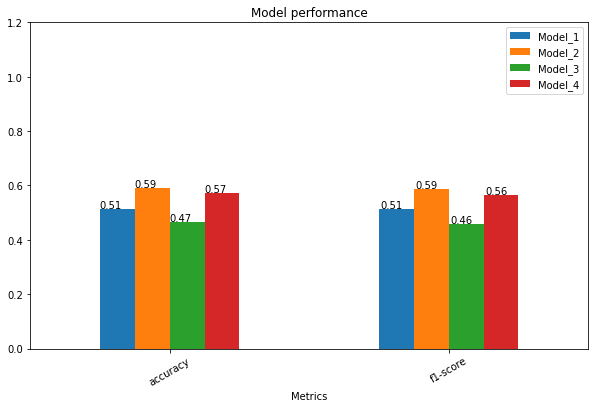

In [30]:
axes = pd.DataFrame({'Model_1':[accuracy_test_model_1, f1_test_model_1],'Model_2':[accuracy_test_model_2, f1_test_model_2],'Model_3':[accuracy_test_model_3, f1_test_model_3],'Model_4':[accuracy_test_model_4, f1_test_model_4]},
                    index=['accuracy', 'f1-score']).plot.bar(figsize=(10, 6))
axes.set_title("Model performance")
axes.set_xlabel('Metrics')
axes.set_ylim(0, 1.2)
plt.sca(axes)
plt.xticks(rotation=30)
for p in axes.patches:
    axes.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
print()

## Conclusions

We classified Arabic statements concerning its dialect. Complete data was successfully collected. These statements have punctuations, repeating words, stop words etc. They were converted into a bag of words representation using several text pre-processing steps. The classification models built on **Arabic Tweets and dialect** performed decently with good accuracy, f1-scores.

We can observe that model performed well when char gram feature with n gram-range(2-5) is used. While the word gram features model suffered *due to a small bag of vocabulary*. F1-score is harmonic mean of precision and recall. It tells how baised is our classifier towards any label. In our case, data is balanced. therefore, f1-score is not much significant for this dataset. But bottm line, f1-score should be high. we can say that  This assignment was good and well designed to make learn and implement test classification models. 
